In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

mm_scaler = MinMaxScaler()
st_scaler = StandardScaler()

In [2]:
df_oil = pd.read_csv('./data/oil_production.csv', encoding='cp949')
df_coal = pd.read_csv('./data/coal_production.csv', encoding='cp949')
df_gas = pd.read_csv('./data/gas_production.csv', encoding='cp949')
df_wti = pd.read_csv('./data/wti_daily.csv', encoding='cp949')
df_other_price = pd.read_csv('./data/energy_price_others.csv', encoding='utf-8')
prices = pd.read_csv('./data/prices.csv', encoding='cp949')

In [3]:
key = '5b4c4ffb733c6280553790b25358670a'
start_date = '1995-01-01'
end_date = '2023-12-31'
fred = Fred(api_key=key)

fred_wti = fred.get_series('DCOILWTICO', observation_start=start_date, observation_end=end_date)

df_wti2 = pd.DataFrame(fred_wti).reset_index()
df_wti2.columns = ['date','wti']

df_wti2 = df_wti2.ffill()
df_wti2 = df_wti2.bfill()

df_wti2.to_csv('./data/wti_daily.csv', encoding='cp949')

In [4]:
def get_scaler(energy, nation):
    df_energy = pd.read_csv(f'./data/{energy}_production.csv', encoding='cp949')

    scaler = StandardScaler()

    df_energy_nation = df_energy[df_energy['nation'] == nation]

    df_energy_nation_type = df_energy_nation[df_energy_nation['description'] != '- 점유율 (%)'].drop('Unnamed: 0', axis=1)

    df_energy_nation_type.columns = ['year','nation','description',energy, 'type']

    scaler.fit(df_energy_nation_type[[energy]])

    return scaler
    

In [5]:
oil_scaler_world = get_scaler('oil', '세계')
coal_scaler_world = get_scaler('coal', '세계')
gas_scaler_world = get_scaler('gas', '세계')

In [6]:
def get_annual_df(nation, type, os, cs, gs):
    df_oil = pd.read_csv('./data/oil_production.csv', encoding='cp949')
    df_coal = pd.read_csv('./data/coal_production.csv', encoding='cp949')
    df_gas = pd.read_csv('./data/gas_production.csv', encoding='cp949')
    df_wti = pd.read_csv('./data/wti_daily.csv', encoding='cp949')

    df_oil_nation = df_oil[df_oil['nation'] == nation]
    df_coal_nation = df_coal[df_coal['nation'] == nation]
    df_gas_nation = df_gas[df_gas['nation'] == nation]

    df_oil_nation_type = df_oil_nation[df_oil_nation['description'] == type + ' (100만 톤)'].drop('Unnamed: 0', axis=1)
    df_coal_nation_type = df_coal_nation[df_coal_nation['description'] == type + ' (exajoules)'].drop('Unnamed: 0', axis=1)
    df_gas_nation_type = df_gas_nation[df_gas_nation['description'] == type + ' (exajoules)'].drop('Unnamed: 0', axis=1)

    df_oil_nation_type = df_oil_nation_type.drop(['nation', 'description','type'],axis=1).reset_index(drop=True)
    df_coal_nation_type = df_coal_nation_type.drop(['nation', 'description','type'],axis=1).reset_index(drop=True)
    df_gas_nation_type = df_gas_nation_type.drop(['nation', 'description','type'],axis=1).reset_index(drop=True)

    df_oil_nation_type['value'] = pd.to_numeric(df_oil_nation_type['value'])
    df_coal_nation_type['value'] = pd.to_numeric(df_coal_nation_type['value'])
    df_gas_nation_type['value'] = pd.to_numeric(df_gas_nation_type['value'])

    df_oil_nation_type.columns = ['year' , 'oil']
    df_coal_nation_type.columns = ['year' , 'coal']
    df_gas_nation_type.columns = ['year' , 'gas']

    df_nation_type = df_oil_nation_type.merge(df_coal_nation_type, on='year', how='outer')
    df_nation_type = df_nation_type.merge(df_gas_nation_type, on='year', how='outer')

    df_nation_type['oil_pct'] = df_nation_type['oil'].pct_change() * 100
    df_nation_type['coal_pct'] = df_nation_type['coal'].pct_change() * 100
    df_nation_type['gas_pct'] = df_nation_type['gas'].pct_change() * 100

    # print(df_nation_type.head(20))

    df_nation_type.iloc[0,4:] = 0

    # df_wti.columns = ['date','wti']
    df_wti['datetime'] = pd.to_datetime(df_wti['date'])
    df_wti['year'] = df_wti['datetime'].dt.year
    df_wti_by_year = df_wti[['year','wti']].groupby('year').mean().reset_index()
    df_wti_by_year['wti_pct'] = df_wti_by_year['wti'].pct_change()
    df_wti_by_year.iloc[0,2] = 0

    df_nation_type = df_nation_type.merge(df_wti_by_year, on='year', how='outer')

    # print(df_nation_type[['oil']])

    df_nation_type['oil_scaled'] = os.transform(df_nation_type[['oil']])
    df_nation_type['coal_scaled'] = cs.transform(df_nation_type[['coal']])
    df_nation_type['gas_scaled'] = gs.transform(df_nation_type[['gas']])
    df_nation_type['wti_scaled'] = st_scaler.fit_transform(df_nation_type[['wti']])

    df_nation_type = df_nation_type.set_index('year')

    return df_nation_type

In [7]:
df_world_produce = get_annual_df('세계', '생산', oil_scaler_world, coal_scaler_world, gas_scaler_world)
df_world_consume = get_annual_df('세계', '소비', oil_scaler_world, coal_scaler_world, gas_scaler_world)

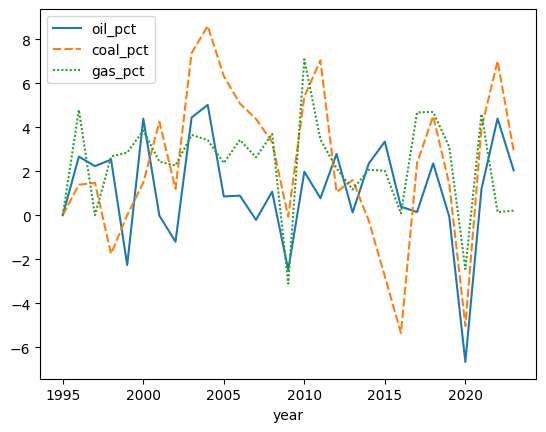

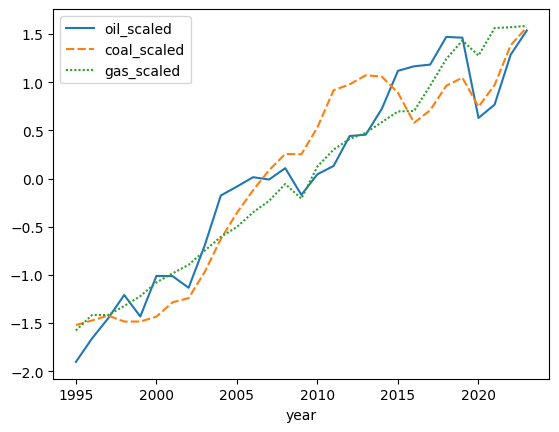

In [8]:
sns.lineplot(df_world_produce[['oil_pct', 'coal_pct', 'gas_pct']])
plt.show()
sns.lineplot(df_world_produce[['oil_scaled','coal_scaled', 'gas_scaled']])
plt.show()

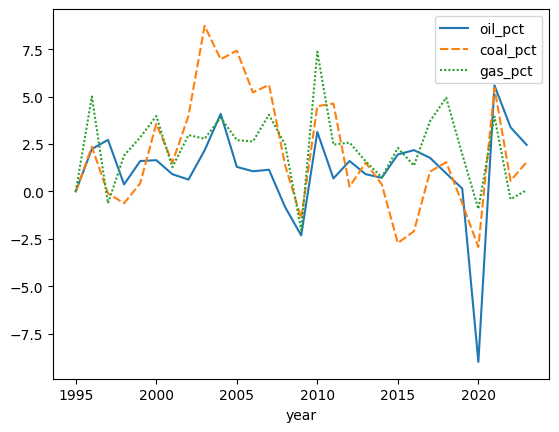

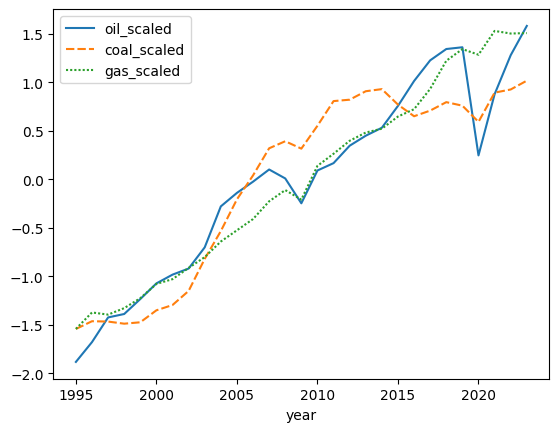

In [9]:
sns.lineplot(df_world_consume[['oil_pct', 'coal_pct', 'gas_pct']])
plt.show()
sns.lineplot(df_world_consume[['oil_scaled','coal_scaled', 'gas_scaled']])
plt.show()

In [10]:
df_world_produce.columns = ['p_oil', 'p_coal', 'p_gas', 'p_oil_pct', 'p_coal_pct', 'p_gas_pct', 'wti', 'wti_pct', 'p_oil_scaled', 'p_coal_scaled', 'p_gas_scaled', 'wti_scaled']
df_world_consume.columns = ['c_oil', 'c_coal', 'c_gas', 'c_oil_pct', 'c_coal_pct', 'c_gas_pct', 'wti', 'wti_pct', 'c_oil_scaled', 'c_coal_scaled', 'c_gas_scaled', 'wti_scaled']
year_index = df_world_produce.index
df_fushion = df_world_produce.merge(df_world_consume, how='left', on=['wti', 'wti_pct', 'wti_scaled'])
df_fushion.index = year_index

# df_fushion['oil_gap'] = (df_fushion['p_oil'] - df_fushion['c_oil']) / df_fushion['p_oil']
# df_fushion['coal_gap'] = (df_fushion['p_coal'] - df_fushion['c_coal']) / df_fushion['p_coal']
# df_fushion['gas_gap'] = (df_fushion['p_gas'] - df_fushion['c_gas']) / df_fushion['p_gas']

df_fushion['oil_gap'] = (df_fushion['p_oil'] - df_fushion['c_oil'])
df_fushion['coal_gap'] = (df_fushion['p_coal'] - df_fushion['c_coal']) 
df_fushion['gas_gap'] = (df_fushion['p_gas'] - df_fushion['c_gas'])

df_fushion['oil_gap'] = st_scaler.fit_transform(df_fushion[['oil_gap']])
df_fushion['coal_gap'] = st_scaler.fit_transform(df_fushion[['coal_gap']])
df_fushion['gas_gap'] = st_scaler.fit_transform(df_fushion[['gas_gap']]) 

In [11]:
df_fushion[df_fushion.index == 2015]['p_oil']

year
2015    4363.9
Name: p_oil, dtype: float64

<Axes: >

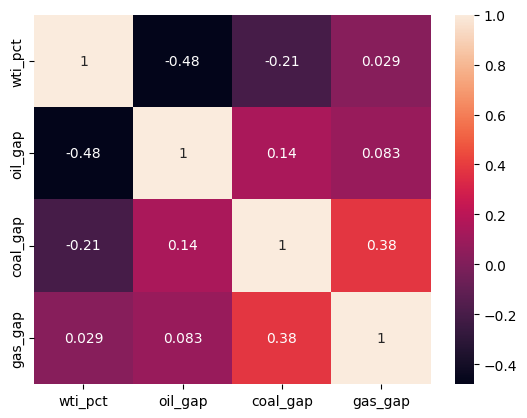

In [12]:
test_df = df_fushion[['wti_pct', 'oil_gap','coal_gap','gas_gap']]
test_df_corr = test_df.corr(method='pearson')
test_df_corr
sns.heatmap(test_df_corr, annot=True)

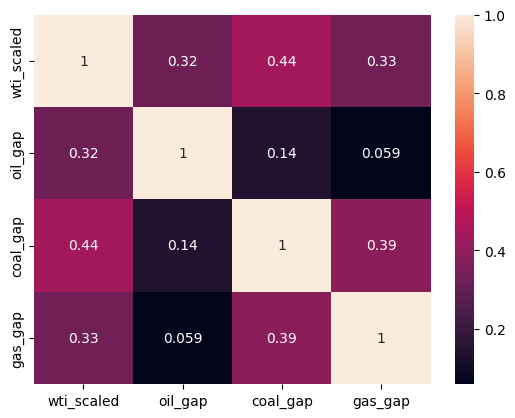

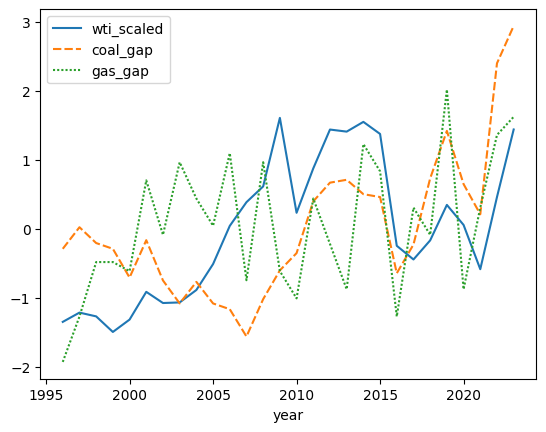

In [13]:
df_test = df_fushion.copy()
df_test['wti_scaled'] = df_test['wti_scaled'].shift(1)
df_test.dropna(inplace=True)

df_test_corr = df_test[['wti_scaled', 'oil_gap','coal_gap','gas_gap']].corr(method='pearson')

sns.heatmap(df_test_corr, annot=True)
plt.show()
sns.lineplot(df_test[['wti_scaled', 'coal_gap','gas_gap']])
plt.show()

<Axes: >

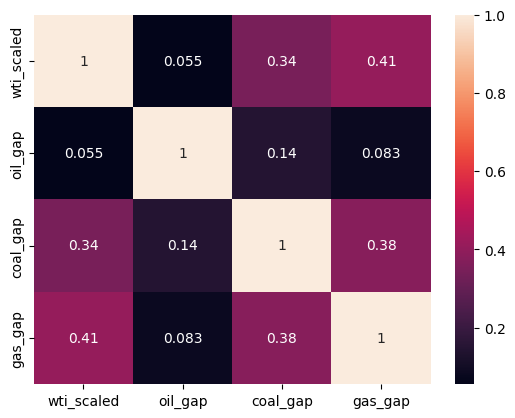

In [14]:
test_df = df_fushion[['wti_scaled', 'oil_gap','coal_gap','gas_gap']]
test_df_corr = test_df.corr(method='pearson')
test_df_corr
sns.heatmap(test_df_corr, annot=True)

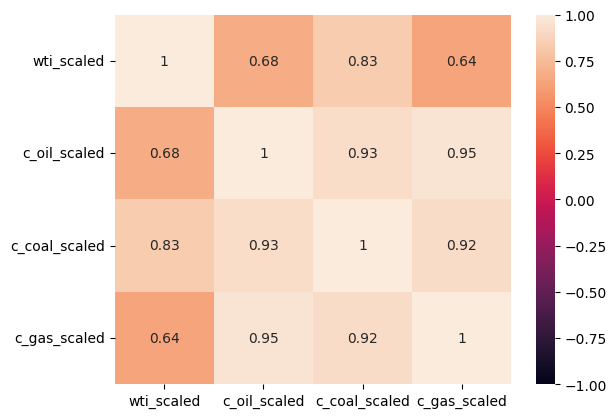

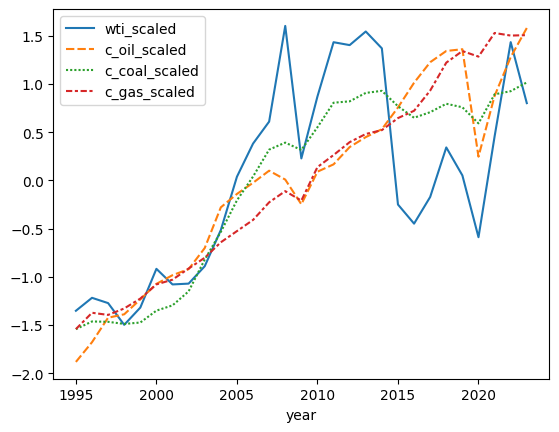

In [15]:
test_df = df_fushion[['wti_scaled', 'c_oil_scaled', 'c_coal_scaled', 'c_gas_scaled']]
test_df_corr = test_df.corr(method='pearson')
test_df_corr
sns.heatmap(test_df_corr, annot=True, vmin=-1, vmax=1)
plt.show()
sns.lineplot(df_fushion[['wti_scaled', 'c_oil_scaled', 'c_coal_scaled', 'c_gas_scaled']])
plt.show()

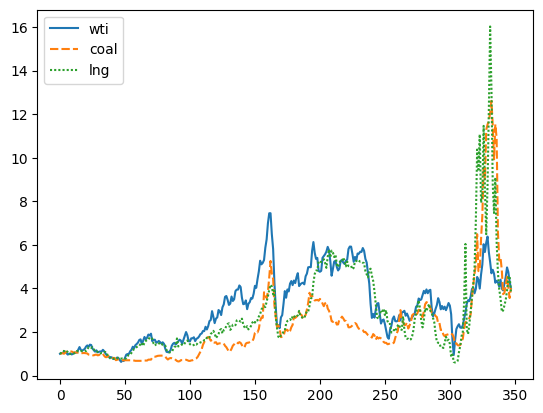

<Axes: >

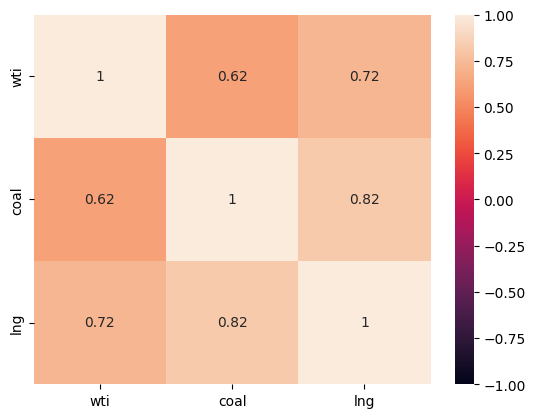

In [16]:
df_prices = prices.copy()
df_prices.columns = ['date', 'wti', 'uranium', 'coal', 'lng']
df_prices.set_index('date', inplace=True)
indicator = df_prices.iloc[0,:]
df_prices = df_prices / indicator

df_prices.reset_index(inplace=True)
df_prices['year'] = df_prices['date'].str[:4]
df_prices['month'] = df_prices['date'].str[5:7]

df_prices = df_prices[['wti','coal','lng', 'year','month']].groupby(['year','month']).mean().reset_index()
df_prices['date'] = df_prices['year'] +'-' + df_prices['month']+'-01'

df_prices_corr = df_prices[['wti','coal','lng']].corr(method='pearson')

sns.lineplot(df_prices.drop(['year','month'], axis=1))
plt.show()
sns.heatmap(df_prices_corr, annot=True, vmax=1, vmin=-1)

In [17]:
df_prices.head()

,year,month,wti,coal,lng,date
0,1995,01,1.000000,1.000000,1.000000,1995-01-01
1,1995,02,1.031492,1.013477,1.047337,1995-02-01
2,1995,03,1.031405,1.033693,1.124260,1995-03-01
3,1995,04,1.099472,1.000000,1.130178,1995-04-01
4,1995,05,1.095548,1.045013,1.097633,1995-05-01


In [18]:
df_m2 = pd.read_csv('./data/indicators.csv', encoding='cp949')
df_m2 = df_m2.dropna()
df_prices_indicators = df_prices.merge(df_m2, on='date', how='left')
m2_indicator = df_prices_indicators['m2'][0]
df_prices_indicators['m2'] = df_prices_indicators['m2'] / m2_indicator
df_prices_indicators['wti_modified'] = df_prices_indicators['wti'] / df_prices_indicators['m2']

In [19]:
df_dollar = pd.read_csv('./data/dollar_idx.csv', encoding='cp949')
df_dollar['year'] = df_dollar['date'].str[:4]
df_dollar['month'] = df_dollar['date'].str[5:7]
df_dollar = df_dollar[['year','month','dollar_idx']].groupby(['year','month']).mean().reset_index()
df_dollar['date'] = df_dollar['year'] +'-' + df_dollar['month']+'-01'
df_prices_indicators_dollar = df_prices_indicators.merge(df_dollar, on=['date','year','month'], how='left')
df_prices_indicators_dollar['dollar_idx'] = df_prices_indicators_dollar['dollar_idx'] / df_prices_indicators_dollar['dollar_idx'][0]
df_prices_indicators_dollar['wti_modified'] = df_prices_indicators_dollar['wti_modified'] * df_prices_indicators_dollar['dollar_idx']

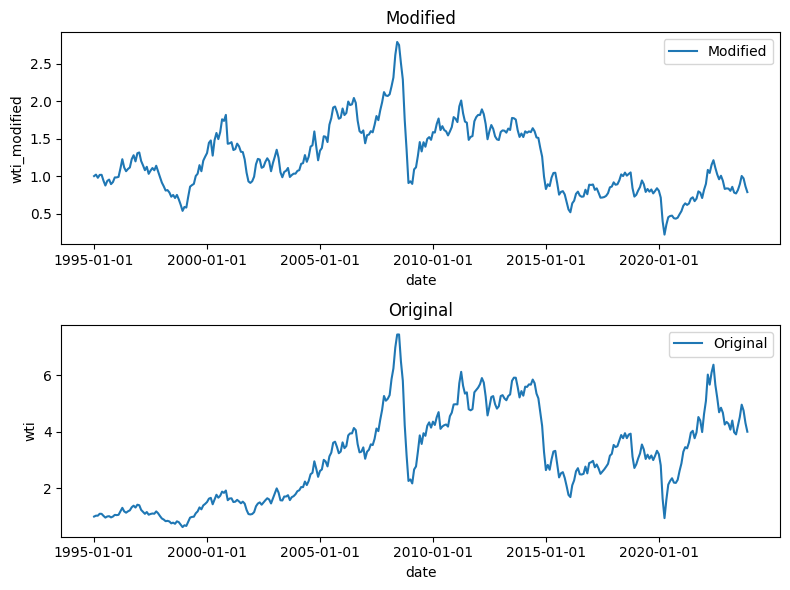

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
sns.lineplot(df_prices_indicators_dollar.set_index('date')['wti_modified'], ax=ax1, label='Modified')
ax1.set_title('Modified')
sns.lineplot(df_prices_indicators_dollar.set_index('date')['wti'], label='Original')
ax2.set_title('Original')
# plt.show()
ax1.set_xticks(range(0, len(df_prices_indicators['m2']), 60), )
ax2.set_xticks(range(0, len(df_prices_indicators['m2']), 60), )
plt.tight_layout()
plt.show()

In [50]:
from scipy import stats
import math

stat, p = stats.shapiro(df_prices_indicators_dollar['dollar_idx'])

print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk Test: Statistics=0.975, p=0.000


In [42]:
df_prices_indicators_dollar

,year,month,wti,coal,lng,date,m2,unemploy,interest,wti_modified,dollar_idx
0,1995,01,1.000000,1.000000,1.000000,1995-01-01,1.000000,5.6,4.94,1.000000,1.000000
1,1995,02,1.031492,1.013477,1.047337,1995-02-01,0.999284,5.4,5.25,1.019786,0.987944
2,1995,03,1.031405,1.033693,1.124260,1995-03-01,0.999628,5.4,5.56,0.977511,0.947394
3,1995,04,1.099472,1.000000,1.130178,1995-04-01,1.001947,5.8,6.30,1.015811,0.925707
4,1995,05,1.095548,1.045013,1.097633,1995-05-01,1.009105,5.6,6.10,1.016800,0.936570
...,...,...,...,...,...,...,...,...,...,...,...
343,2023,08,4.526759,4.118397,3.477205,2023-08-01,5.937207,3.7,5.33,0.891510,1.169286
344,2023,09,4.964475,4.541215,3.890976,2023-09-01,5.921830,3.8,5.33,1.001504,1.194635
345,2023,10,4.754646,4.063027,4.524677,2023-10-01,5.916419,3.9,5.33,0.969364,1.206222
346,2023,11,4.315523,3.561168,4.560299,2023-11-01,5.920227,3.7,5.33,0.864174,1.185512


<Axes: >

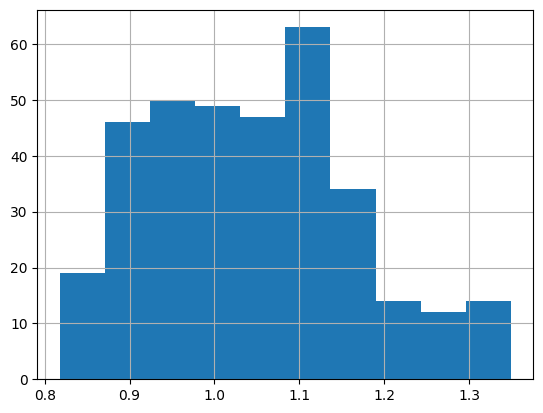

In [41]:
df_prices_indicators_dollar['dollar_idx'].hist()

In [21]:
df_prices_indicators_dollar.to_csv('./data/price_modified.csv', encoding='cp949')

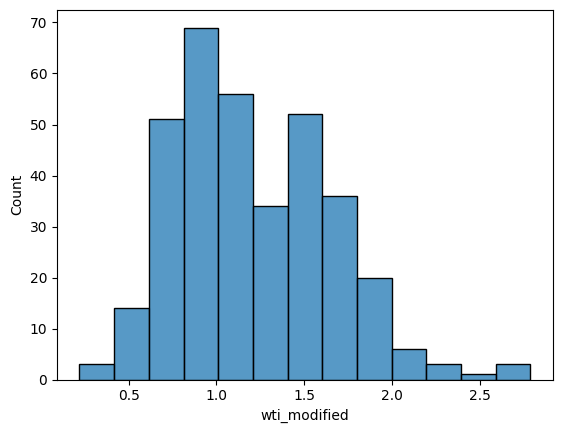

In [22]:
sns.histplot(df_prices_indicators_dollar.set_index('date')['wti_modified'],  label='Modified')
plt.show()

<Axes: xlabel='year'>

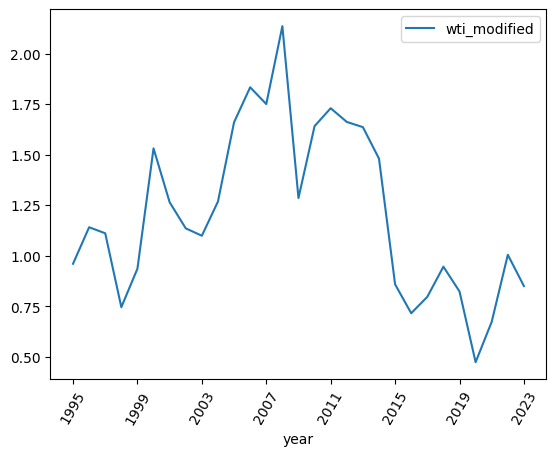

In [23]:
plt.xticks(range(0, 30, 4), rotation=60)
sns.lineplot(df_prices_indicators_dollar[['year','wti_modified']].groupby('year').mean())

In [24]:
df_gdp = pd.read_csv('./data/gdp_std.csv', encoding='cp949')
df_gdp.columns = ['year','gdp','growth','std-z']
df_check = df_prices_indicators_dollar[['year','wti_modified', 'wti']].groupby('year').mean().reset_index()
df_gdp['year'] = df_gdp['year'].apply(lambda x: str(x))
df_check = df_check.merge(df_gdp, on='year',how='left')
# df_check['wti_pct'] = df_check['wti_modified'].pct_change()
df_check['wti_pct'] = df_check['wti'].pct_change()
df_check.dropna(inplace=True)
df_check['wti_pct'].corr(df_check['std-z'])

np.float64(0.6682935474074592)

<Axes: xlabel='year'>

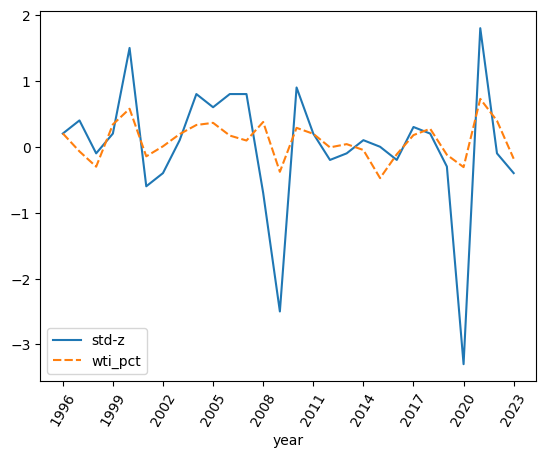

In [25]:
plt.xticks(range(0, 30, 3), rotation=60)
sns.lineplot(df_check.set_index('year')[['std-z','wti_pct']])

In [26]:
df_gold = pd.read_csv('./data/gold.csv', encoding='cp949')
df_gold.columns = ['date', 'gold']
df_gold['year'] = df_gold['date'].str[:4]
df_gold['month'] = df_gold['date'].str[5:7]
df_gold_month = df_gold[['year','month','gold']].groupby(['year','month']).mean().reset_index()

In [27]:
df_gold_month = df_gold_month.merge(df_dollar,on=['year','month'], how='left')

In [28]:
df_gold_month['gold'].corr(df_gold_month['dollar_idx'])

np.float64(-0.1700981257515777)